In [2]:
import numpy as np
import numpy.random as rnd
import tensorflow as tf
print(tf.__version__)
import tensorflow_probability as tfp
import gpflow
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
%matplotlib inline
plt.style.use('ggplot')

1.15.0-rc2


In [3]:
# func = lambda x, y: np.array([[x**2 + y**2], [x**2 + 2*y**2]])
func1 = lambda x, y: x**2 + y**2
func2 = lambda x, y: x**2 - y**2

In [4]:
def plot_contour(ax, x, y, z, a=None, contour=None, inputs=False):
    # surf = ax.contourf(x, y, z, cmap=cm.cool, linewidth=0, antialiased=False)
    surf = ax.contourf(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    cont = None
    if contour is not None and a is not None:
        cont = ax.contour(x, y, a, levels=contour)
    if contour is not None and a is None:
        cont = ax.contour(x, y, z, levels=contour)
    if inputs is True:
        # plt.plot(x.flatten(), y.flatten(), 'xk')
        plt.plot(X_[:, 0], X_[:, 1], 'xk')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    return surf, cont

def plot_contourf(x, y, z, a=None, contour=None, title=None, inputs=False):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.gca()
    surf, cont = plot_contour(ax, x, y, z, a, contour, inputs=inputs)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(title)
    plt.show()

def plot_contourf_var(x, y, z, z_var, a=None, contour=None, title=None, inputs=False):
    # fig, axs = plt.subplot(2, sharex=True, sharey=True)
    fig, axs = plt.subplots(1, 2,figsize=(24, 4))
    plt.subplots_adjust(wspace=0, hspace=0)

    surf_mu, cont_mu = plot_contour(axs[0], x, y, z, a, contour, inputs)
    fig.colorbar(surf_mu, shrink=0.5, aspect=5, ax=axs[0])
    surf_var, cont_var = plot_contour(axs[1], x, y, z_var, a, contour, inputs)
    fig.colorbar(surf_var, shrink=0.5, aspect=5, ax=axs[1])

    plt.suptitle(title)
    plt.show()

def gen_data(N=100, x_scale=1., y_scale=1., num_mixtures=5, low_noise_var=0.005, high_noise_var=0.3, plot_flag=[0, 0, 0]):
    N = int(np.sqrt(N))
    # x_ = np.random.rand(N, 1) * 2 - 1 # X values
    x_ = np.random.rand(N+10, 1) * 2 * x_scale - 1 * x_scale # X values
    y_ = np.random.rand(N+10, 1) * 2 * y_scale - 1 * y_scale # X values

    x_ = np.sort(x_, axis=0)
    y_ = np.sort(y_, axis=0)

    x_ = np.delete(x_, np.arange(5, 15), 0)
    y_ = np.delete(y_, np.arange(0, 10), 0)

    x, y = np.meshgrid(x_, y_)
    # x, y = np.mgrid[x_min:x_max:N*1j, x_min:x_max:N*1j]
    xy = np.column_stack([x.flat, y.flat]) # Need an (N, 2) array - N (x, y) pairs.

    # generate alpha (separation) from a mixture of gaussians
    means = np.random.rand(num_mixtures, 2) * 2 - 1
    covs = np.random.rand(num_mixtures, 2, 2) * 0.5
    covs = [np.diag(np.diag(covs[i, :, :])) for i in range(num_mixtures)]
    a = sum([multivariate_normal.pdf(xy, mean=mean, cov=cov) for mean, cov in zip(means, covs)])

    # Reshape back to a (N, N) grid and rescale to range 0, 1
    a = a.reshape(x.shape)
    a = np.interp(a, (a.min(), a.max()), (0, +1))

    # Generate outputs using f(x, y) = x**2 + y**2
    z = np.zeros([N**2, 2])
    z[:, 0:1] = func1(x.reshape(-1, 1), y.reshape(-1, 1))
    z[:, 1:2] = func2(x.reshape(-1, 1), y.reshape(-1, 1))
    # if plot_flag[1] is 1:
    #     plot_contourf(x, y, z[:, 0].reshape(x.shape), title='y1 - no noise')
    #     plot_contourf(x, y, z[:, 1].reshape(x.shape), title='y2 - no noise')

    # a = np.zeros(x.shape)
    # a[:10, :10] = 1
    if plot_flag[0] is 1:
        plot_contourf(x, y, a, contour=[0.5], title='alpha')

    # Add noise where alpha > 0.5
    aa = np.tile(a.reshape(-1, 1), z.shape[1]) # broadcast a along output dimension
    z = np.where(aa>0.5, z+high_noise_var*np.random.randn(*z.shape), z+low_noise_var*np.random.randn(*z.shape))
    if plot_flag[2] is 1:
        plot_contourf(x, y, z[:, 0].reshape(x.shape), a, contour=[0.5], title='y - noisy')
        plot_contourf(x, y, z[:, 1].reshape(x.shape), a, contour=[0.5], title='y - noisy')

    return xy, z.reshape(-1, 2), a.reshape(-1, 1)

/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'linewidth'
  This is separate from the ipykernel package so we can avoid doing imports until


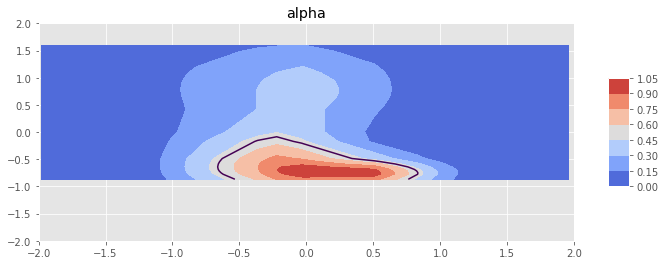

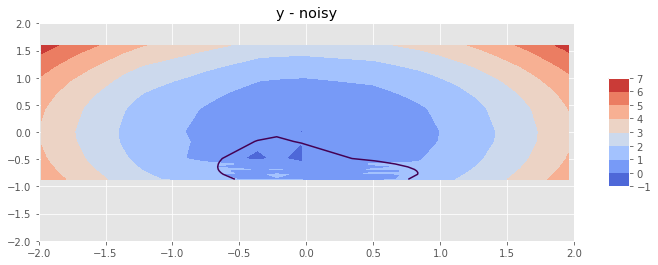

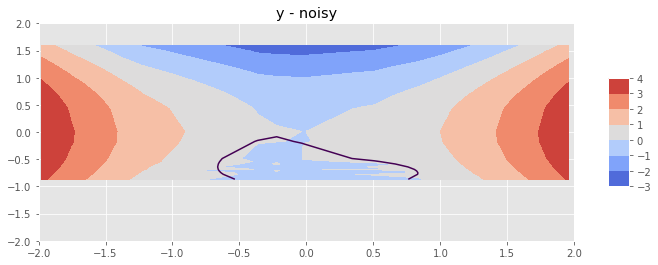

(961, 2)
(961, 1)
(961, 2)


In [6]:
N = 1000 # number of training observations
X, Y, a = gen_data(N=N, num_mixtures=5, x_scale=2., y_scale=2., plot_flag=[1, 1, 1])
# X, Y, a = gen_data(N=N, num_mixtures=1, plot_flag=[1, 1, 1])
# Y = Y[:, 0:1]
# Y = Y[:, 1:2]
print(X.shape)
print(a.shape)
print(Y.shape)

In [7]:
class Logger(gpflow.actions.Action):
    def __init__(self, model):
        self.model = model
        self.logf = []

    def run(self, ctx):
        if (ctx.iteration % 10) == 0:
            # Extract likelihood tensor from Tensorflow session
            likelihood = - ctx.session.run(self.model.likelihood_tensor)
            # Append likelihood value to list
            self.logf.append(likelihood)

In [8]:
from gpflow.training import monitor as mon
def run_adam(model, maxiter=450):
    # Create an Adam Optimiser action
    adam = gpflow.train.AdamOptimizer().make_optimize_action(model)
    # Create a Logger action
    logger = Logger(model)
    actions = [adam, logger]
    # Create optimisation loop that interleaves Adam with Logger
    loop = gpflow.actions.Loop(actions, stop=maxiter)()
    # Bind current TF session to model
    model.anchor(model.enquire_session())
    return logger

def plot_loss(logger):
    plt.plot(-np.array(logger.logf))
    plt.xlabel('iteration (x10)')
    plt.ylabel('ELBO');

In [9]:
def plot_model2D(m, f=False, a=False, a_true=None, h=False, y=False, y_true=False, y_a=None, inputs=False, var=False):

    N = int(np.sqrt(m.X.value.shape[0]))
    # low = -1; high = 1
    # low = -1.5; high = 1.5
    low = -2; high = 2
    xx, yy = np.mgrid[low:high:N*1j, low:high:N*1j]
    # Need an (N, 2) array of (x, y) pairs.
    xy = np.column_stack([xx.flat, yy.flat])

    mx = m.X.value[:, 0].reshape(N, N)
    my = m.X.value[:, 1].reshape(N, N)
    mz1 = m.Y.value[:, 0].reshape(N, N)
    mz2 = m.Y.value[:, 1].reshape(N, N)

    if a is True:
        a_mu, a_var = m.predict_a(xy)  # Predict alpha values at test locations
        # plot_contourf(xx, yy, a_mu.reshape(xx.shape), contour=[0.5], title='predicted alpha')
        # plot_contourf(xx, yy, 1-a_mu.reshape(xx.shape), contour=[0.5], title='predicted alpha inverted')
        plot_contourf_var(xx, yy, a_mu.reshape(xx.shape), a_var.reshape(xx.shape), contour=[0.5], title='predicted alpha', inputs=inputs)
        plot_contourf_var(xx, yy, 1-a_mu.reshape(xx.shape), a_var.reshape(xx.shape), contour=[0.5], title='predicted alpha inverted', inputs=inputs)

    if a_true is not None:
        plot_contourf(mx, my, a_true.reshape(xx.shape), contour=[0.5], title='Original alpha', inputs=inputs)

    if f is True:
        f_mus, f_vars = m.predict_f(xy)  # Predict alpha values at test locations
        for i, (f_mu, f_var) in enumerate(zip(f_mus, f_vars)):
            plot_contourf_var(xx, yy, f_mu[:, 0].reshape(xx.shape), f_var[:, 0].reshape(xx.shape), title=('predicted $f_%i$ dim 1' % i), inputs=inputs)
            plot_contourf_var(xx, yy, f_mu[:, 1].reshape(xx.shape), f_var[:, 1].reshape(xx.shape), title=('predicted $f_%i$ dim 2' % i), inputs=inputs)

    if y is True:
        y_mu, y_var = m.predict_y(xy)  # Predict alpha values at test locations
        print(y_mu.shape)
        if y_a is not None:
            # plot_contourf(xx, yy, y_mu.reshape(xx.shape), a=y_a.reshape(xx.shape), contour=[0.5], title='predicted y')
            # plot_contourf_var(xx, yy, y_mu.reshape(xx.shape), y_var.reshape(xx.shape), title='predicted y', inputs=inputs)
            plot_contourf_var(xx, yy, y_mu[:, 0].reshape(xx.shape), y_var[:, 0].reshape(xx.shape), title='predicted y dim 1', inputs=inputs)
            plot_contourf_var(xx, yy, y_mu[:, 1].reshape(xx.shape), y_var[:, 1].reshape(xx.shape), title='predicted y dim 2', inputs=inputs)
        else:
            plot_contourf_var(xx, yy, y_mu[:, 0].reshape(xx.shape), y_var[:, 0].reshape(xx.shape), title='predicted y dim 1', inputs=inputs)
            plot_contourf_var(xx, yy, y_mu[:, 1].reshape(xx.shape), y_var[:, 1].reshape(xx.shape), title='predicted y dim 2', inputs=inputs)
            # plot_contourf(xx, yy, y_mu.reshape(xx.shape), y_var.reshape(xx.shape), title='predicted y', inputs=inputs)
            # TODO: how to plot variance of GPs??

    if y_true is True:
        if y_a is not None:
            plot_contourf(mx, my, mz1, a=y_a.reshape(mx.shape), contour=[0.5], title='original y dim 1', inputs=inputs)
            plot_contourf(mx, my, mz2, a=y_a.reshape(mx.shape), contour=[0.5], title='original y dim 2', inputs=inputs)
        else:
            plot_contourf(mx, my, mz1, title='original y dim 1', inputs=inputs)
            plot_contourf(mx, my, mz2, title='original y dim 2', inputs=inputs)

    if var is True:
        lik_var, f_var = m.predict_vars(xy)
        plot_contourf_var(xx, yy, lik_var.reshape(xx.shape), f_var.reshape(xx.shape), title='noise variance vs GP covariance', inputs=inputs)

# plot_model2D(m, a=True, a_true=a, y=True, y_true=True, y_a=a)
# plot_model2D(m, a=True, a_true=a)
# plot_model2D(m, f=True, y_true=True, y_a=a)
# plot_model2D(m, f=True)

In [10]:
from gpflow import kullback_leiblers, settings, transforms, features
from gpflow.conditionals import conditional, Kuu
from gpflow.decors import params_as_tensors
from gpflow.models.model import GPModel
from gpflow.params import DataHolder, Minibatch, Parameter, ParamList
from gpflow.mean_functions import Zero
from gpflow.models.model import Model
from gpflow.decors import params_as_tensors, autoflow
from gpflow.quadrature import ndiagquad
from gpflow.multioutput import kernels as mk
from gpflow.multioutput import features as mf

float_type = gpflow.settings.float_type

In [11]:
from gpflow.likelihoods import Likelihood, SwitchedLikelihood, Gaussian, Bernoulli

def inv_probit(x):
    jitter = 1e-3  # ensures output is strictly between 0 and 1
    return 0.5 * (1.0 + tf.erf(x / np.sqrt(2.0))) * (1 - 2 * jitter) + jitter


class BernoulliGaussian(Likelihood):
    # def __init__(self, variance_low=0.005, variance_high=0.3, invlink=inv_probit, **kwargs):
    def __init__(self, variance_low=np.array([[0.005, 0.], [0., 0.005]]), variance_high=np.array([[0.3, 0.], [0., 0.3]]), invlink=inv_probit, **kwargs):
    # def __init__(self, variance_low=np.array([0.005, 0.005]), variance_high=np.array([0.3, 0.3]), invlink=inv_probit, **kwargs):
        super().__init__(**kwargs)
        self.invlink = invlink
        transform = transforms.DiagMatrix(2)(transforms.positive)
        variance_low = Parameter(
            variance_low, transform=transform, dtype=settings.float_type)
        variance_high = Parameter(
            variance_high, transform=transform, dtype=settings.float_type)
        # variance_low = Parameter(
        #     variance_low, transform=transforms.positive, dtype=settings.float_type)
        # variance_high = Parameter(
        #     variance_high, transform=transforms.positive, dtype=settings.float_type)

        variances = [variance_low, variance_high]
        self.variances = ParamList(variances)
        self.likelihood_bern = Bernoulli()
#         self.variance_low.trainable = False
#         self.variance_high.trainable = False

    @params_as_tensors
    def predict_mean_and_var(self, Fmu, Fvar, idx):
        # TODO: will this work in 1D?
        return tf.identity(Fmu), Fvar + tf.diag_part(tf.squeeze(self.variances[idx]))
        # return tf.identity(Fmu), Fvar + self.variances[idx]

    @params_as_tensors
    def predict_mean_and_var_a(self, Hmu, Hvar):
        return self.likelihood_bern.predict_mean_and_var(Hmu, Hvar)

    @params_as_tensors
    def predict_mean_a(self, H):
        return inv_probit(H)

In [42]:
class BMNSVGP(Model):

    def __init__(self, X, Y, var_low, var_high, minibatch_size=None):
        """
        - X is a data matrix, size N x D
        - Y is a data matrix, size N x P
        """
        Model.__init__(self, name="BMNSVGP")
        if minibatch_size is not None:
            self.X = Minibatch(X, batch_size=minibatch_size, seed=0)
            self.Y = Minibatch(Y, batch_size=minibatch_size, seed=0)
        else:
            self.X = Dataholder(X)
            self.Y = Dataholder(Y)

        self.num_data = X.shape[0]
        self.input_dim = X.shape[1]
        self.output_dim = Y.shape[1]
        self.whiten = True
        # self.whiten = False
#         num_inducing = len(self.feature)

        # init separation GP
        self.mean_function_h = Zero(output_dim=1)
        self.kern_h = gpflow.kernels.RBF(input_dim=self.input_dim, ARD=True)
        feat = None
        M = 50
        idx = np.random.choice(range(self.num_data), size=M, replace=False)
        Z = X[idx, ...].reshape(-1, self.input_dim)
        self.feature_h = features.inducingpoint_wrapper(feat, Z)
        self.feature_h.trainable = False
        # init variational parameters
        # TODO: auto select number of inducing points
        q_mu_h = np.zeros((M, 1)) + rnd.randn(M, 1)
        q_sqrt_h = np.array([10*np.eye(M, dtype=settings.float_type) for _ in range(1)])
        self.q_mu_h, self.q_sqrt_h = self._init_variational_parameters(num_inducing=M, num_latent=1, q_mu=q_mu_h, q_sqrt=q_sqrt_h)
        #         self.q_mu_h, self.q_sqrt_h = self._init_variational_parameters(num_inducing=50, num_latent=1)

        # init 2 dynamics GPs for each output dimension
        kernels, mean_functions, feat_list, q_mus, q_sqrts = [], [], [], [], []

        # init dynamics GPs for each mode
        # TODO: change 2 to the number of dynamics GPs
        for i in range(2):
            # init mean functions
            mean_functions.append(Zero(output_dim=self.output_dim))

            # init kernels
            # Create list of kernels for each output
            kern_list = [gpflow.kernels.RBF(self.input_dim, ARD=True) for _ in range(self.output_dim)]
            # kern = gpflow.kernels.RBF(input_dim=self.input_dim, ARD=True)
            # Create multioutput kernel from kernel list
            kern = mk.SeparateIndependentMok(kern_list)
            kernels.append(kern)

            # init features
            # initialisation of inducing input locations, one set of locations per output
            Zs = [X[np.random.permutation(len(X))[:M],...].copy() for _ in range(self.output_dim)]
            # initialise as list inducing features
            feature_list = [gpflow.features.InducingPoints(Z) for Z in Zs]
            # create multioutput features from feature_list
            feature = mf.SeparateIndependentMof(feature_list)
            feature.trainable = False
            # idx = np.random.choice(range(self.num_data), size=M, replace=False)
            # Z = X[idx, ...].reshape(-1, self.input_dim)
            # feature = features.inducingpoint_wrapper(feat, Z)
            # feature.trainable = False
            feat_list.append(feature)

            # init variational inducing points
            q_mu, q_sqrt = self._init_variational_parameters(num_inducing=M, num_latent=self.output_dim)
            # q_mu = np.zeros((M, 1)) + rnd.randn(M, 1)
            # q_sqrt = np.array([10*np.eye(M, dtype=settings.float_type) for _ in range(1)])
            q_mus.append(q_mu)
            q_sqrts.append(q_sqrt)

        self.kernels = ParamList(kernels)
        self.features = ParamList(feat_list)
        self.mean_functions = ParamList(mean_functions)
        self.q_mus = ParamList(q_mus)
        self.q_sqrts = ParamList(q_sqrts)

        # init likelihood
        self.likelihood = BernoulliGaussian(variance_low=var_low, variance_high=var_high)

    def _init_variational_parameters(self, num_inducing, num_latent, q_mu=None, q_sqrt=None, q_diag=None):
        q_mu = np.zeros((num_inducing, num_latent)) if q_mu is None else q_mu
        q_mu = Parameter(q_mu, dtype=settings.float_type)  # M x P

        if q_sqrt is None:
            if q_diag:
                q_sqrt = Parameter(np.ones((num_inducing, num_latent), dtype=settings.float_type),
                                        transform=transforms.positive)  # M x P
            else:
                q_sqrt = np.array([np.eye(num_inducing, dtype=settings.float_type) for _ in range(num_latent)])
                q_sqrt = Parameter(q_sqrt, transform=transforms.LowerTriangular(num_inducing, num_latent))  # P x M x M
        else:
            if q_diag:
                assert q_sqrt.ndim == 2
                num_latent = q_sqrt.shape[1]
                q_sqrt = Parameter(q_sqrt, transform=transforms.positive)  # M x L/P
            else:
                assert q_sqrt.ndim == 3
                num_latent = q_sqrt.shape[0]
                num_inducing = q_sqrt.shape[1]
                q_sqrt = Parameter(q_sqrt, transform=transforms.LowerTriangular(num_inducing, num_latent))  # L/P x M x M
        return q_mu, q_sqrt

    @params_as_tensors
    def build_prior_KL(self, feature, kern, q_mu, q_sqrt):
        if self.whiten:
            K = None
        else:
            K = Kuu(feature, kern, jitter=settings.numerics.jitter_level)  # (P x) x M x M

        return kullback_leiblers.gauss_kl(q_mu, q_sqrt, K)

    @params_as_tensors
    def _sample_e_h(self, dist_h, f_means, num_samples=1000):
        h = tf.reshape(dist_h.sample(num_samples), [-1, num_samples])
        p_a_0 = 1 - inv_probit(h)
        p_y = []
        # var1 = self.likelihood.variances[0][0, 0, 0]
        # var2 = self.likelihood.variances[1][0, 0, 0]
        # self._var1 = var1
        # dist_f1 = tf.distributions.Normal(loc=f_means[0][:, 0], scale=var1)
        # dist_f2 = tf.distributions.Normal(loc=f_means[0][:, 1], scale=var2)
        # self._dist_f1 = dist_f1
        # self._f_mean = f_means[0][:, 0]
        # print(self.Y[:, 0])
        # p_y1 = dist_f1.prob(self.Y[:, 0])
        # p_y2 = dist_f2.prob(self.Y[:, 1])
        # self._sumh = tf.log(p_y1 * p_a_0 + p_y2 * (1 - p_a_0))
        for f_mean, variance in zip(f_means, self.likelihood.variances):
            dist_y = tfp.distributions.MultivariateNormalFullCovariance(loc=f_mean, covariance_matrix=variance)
            p_y.append(dist_y.prob(self.Y))
        return 1./(num_samples**2) * tf.reduce_sum(tf.log(p_y[0] * p_a_0 + p_y[1] * (1 - p_a_0)), axis=1)

    @property
    @autoflow()
    def dist_f1(self):
        return self._dist_f1

    @property
    @autoflow()
    def var1(self):
        return self._var1

    @property
    @autoflow()
    def f_mean(self):
        return self._f_mean

    @property
    @autoflow()
    def f_means(self):
        return self._f_means

    @property
    @autoflow()
    def dist_fs(self):
        return self._dist_fs

    @property
    @autoflow()
    def var_exp_f(self):
        return self._var_exp_f

    @property
    @autoflow()
    def sumh(self):
        return self._sumh

    @property
    @autoflow()
    def sumf(self):
        return self._sum

    @property
    @autoflow()
    def var_exp_h(self):
        return self._var_exp_h

    @params_as_tensors
    # TODO: num_samples must equal 1 for the optimisation to work. fix this error
    def _sample_e_f(self, dist_fs, h, num_samples=1000):
        p_a_0 = 1 - inv_probit(h)
        p_y = []
        for dist_f, variance in zip(dist_fs, self.likelihood.variances):
            f = dist_f.sample(num_samples)
            dist_y = tfp.distributions.MultivariateNormalFullCovariance(loc=f, covariance_matrix=variance)
            p_y.append(dist_y.prob(self.Y))
        self._sum = tf.log(p_y[0] * p_a_0 + p_y[1] * (1 - p_a_0))
        return 1./(num_samples**2) * tf.reduce_sum(tf.log(p_y[0] * p_a_0 + p_y[1] * (1 - p_a_0)), axis=1)

    @params_as_tensors
    def _build_likelihood(self):
        """
        This gives a variational bound on the model likelihood.
        """
        # Get prior KL.
        KL_h = self.build_prior_KL(self.feature_h, self.kern_h, self.q_mu_h, self.q_sqrt_h)

        # Lets get conditional p(h_n | U_h, x_n) for all N
        h_mean, h_var = self._build_predict_h(self.X, full_cov=False, full_output_cov=False)
        dist_h = tf.distributions.Normal(loc=h_mean, scale=h_var)

        KL_f = 0
        f_means, f_vars, dist_fs = [], [], []
        for feature, kern, mean_function, q_mu, q_sqrt in zip(self.features, self.kernels,self.mean_functions, self.q_mus, self.q_sqrts):
            # Get prior KL.
            KL_f += self.build_prior_KL(feature, kern, q_mu, q_sqrt)

            # Lets get conditionals p(f_n_1 | U_f_1, x_n) and p(f_n_2 | U_f_2, x_n) for all N
            f_mean, f_var = self._build_predict_f(self.X, feature, kern, mean_function, q_mu, q_sqrt, full_cov=False, full_output_cov=False)
            f_means.append(f_mean)
            f_vars.append(f_var)

            # TODO: multivariate_normal or normal?
             # tfp.distributions.MultivariateNormalFullCovariance(loc=f, covariance_matrix=variance)
            dist_fs.append(tfp.distributions.MultivariateNormalDiag(loc=f_mean, scale_diag=f_var))
            # dist_fs.append(tf.distributions.Normal(loc=f_mean, scale=f_var))

        self._dist_fs = dist_fs
        self._f_means = f_means
        # Lets calculate the variatonal expectations
        var_exp_h = self._sample_e_h(dist_h, f_means, num_samples=1)
        var_exp_f = self._sample_e_f(dist_fs, h_mean, num_samples=1)
        self._var_exp_h = var_exp_h
        self._var_exp_f = var_exp_f
        var_exp = var_exp_f + var_exp_h

        # re-scale for minibatch size
        scale = tf.cast(self.num_data, settings.float_type) / tf.cast(tf.shape(self.X)[0], settings.float_type)
        return tf.reduce_sum(var_exp) * scale - KL_f - KL_h

    @params_as_tensors
    def _build_predict_h(self, Xnew, full_cov=False, full_output_cov=False):
        mu, var = conditional(Xnew, self.feature_h, self.kern_h, self.q_mu_h, q_sqrt=self.q_sqrt_h, full_cov=full_cov,
                              white=self.whiten, full_output_cov=full_output_cov)
        return mu + self.mean_function_h(Xnew), var

    @params_as_tensors
    def _build_predict_f(self, Xnew, feature, kern, mean_function, q_mu, q_sqrt, full_cov=False, full_output_cov=False):
        mu, var = conditional(Xnew, feature, kern, q_mu, q_sqrt=q_sqrt, full_cov=full_cov, white=self.whiten, full_output_cov=full_output_cov)
        return mu + mean_function(Xnew), var

    @autoflow((settings.float_type, [None, None]))
    def predict_a(self, Xnew):
        h_mean, h_var = self._build_predict_h(Xnew)
        return self.likelihood.predict_mean_and_var_a(h_mean, h_var)

    @autoflow((settings.float_type, [None, None]))
    def predict_h(self, Xnew):
        return self._build_predict_h(Xnew)

    @autoflow((settings.float_type, [None, None]))
    @params_as_tensors
    def predict_f(self, Xnew):
        means, variances = [], []
        for idx, (feature, kern, mean_function, q_mu, q_sqrt) in enumerate(zip(self.features, self.kernels,self.mean_functions, self.q_mus, self.q_sqrts)):
            mean, variance = self._build_predict_f(Xnew, feature, kern, mean_function, q_mu, q_sqrt)
            # mean, variance = self.likelihood.predict_mean_and_var(mean, variance, idx)
            means.append(mean)
            variances.append(variance)
        return means, variances

    # @autoflow((settings.float_type, [None, None]))
    @params_as_tensors
    def predict_vars(self, Xnew):
        # TODO: how to propagate unc from a to y
        a_mean, a_var = self.predict_a(Xnew)
        lik_vars = self.likelihood.variances
        f_vars = []
        for idx, (feature, kern, mean_function, q_mu, q_sqrt) in enumerate(zip(self.features, self.kernels,self.mean_functions, self.q_mus, self.q_sqrts)):
            _, f_var = self._build_predict_f(Xnew, feature, kern, mean_function, q_mu, q_sqrt)
            f_vars.append(f_var)
        f_var = f_vars[0] * (1-a_mean) + f_vars[1] * a_mean
        lik_var = lik_vars[0] * (1-a_mean) + lik_vars[1] * a_mean
        return f_var, lik_var

    @autoflow((settings.float_type, [None, None]))
    @params_as_tensors
    def predict_vars(self, Xnew):
        f_means, f_vars, y_means, y_vars = [], [], [], []
        for idx, (feature, kern, mean_function, q_mu, q_sqrt) in enumerate(zip(self.features, self.kernels,self.mean_functions, self.q_mus, self.q_sqrts)):
            f_mean, f_var = self._build_predict_f(Xnew, feature, kern, mean_function, q_mu, q_sqrt)
            # y_mean, y_var = self.likelihood.predict_mean_and_var(f_mean, f_var, idx)
            f_means.append(f_mean)
            f_vars.append(f_var)
        h_mean, h_var = self._build_predict_h(Xnew)
        a_mean, a_var =  self.likelihood.predict_mean_and_var_a(h_mean, h_var)
        noise_vars = self.likelihood.variances
        noise_var = noise_vars[0] * (1-a_mean) + noise_vars[1] * a_mean
        f_var = f_vars[0] * (1-a_mean) + f_vars[1] * a_mean
        return noise_var, f_var

    @autoflow((settings.float_type, [None, None]))
    @params_as_tensors
    def predict_y(self, Xnew):
        y_means, y_vars = [], []
        for idx, (feature, kern, mean_function, q_mu, q_sqrt) in enumerate(zip(self.features, self.kernels,self.mean_functions, self.q_mus, self.q_sqrts)):
            f_mean, f_var = self._build_predict_f(Xnew, feature, kern, mean_function, q_mu, q_sqrt)
            y_mean, y_var = self.likelihood.predict_mean_and_var(f_mean, f_var, idx)
            y_means.append(y_mean)
            y_vars.append(y_var)
        h_mean, h_var = self._build_predict_h(Xnew)
        a_mean, a_var =  self.likelihood.predict_mean_and_var_a(h_mean, h_var)
        print(y_means[0].shape)
        print(y_means[1].shape)
        print(y_vars[0].shape)
        print(y_vars[1].shape)
        y_mean = y_means[0] * (1-a_mean) + y_means[1] * a_mean
        y_var = y_vars[0] * (1-a_mean) + y_vars[1] * a_mean
        return y_mean, y_var

In [43]:
gpflow.reset_default_graph_and_session()
X_ = (X - X.mean()) / X.std()
Y_ = (Y - Y.mean()) / Y.std()
print(X.shape)
print(Y.shape)
var_low = np.array([[[0.005, 0.], [0., 0.005]]])
var_high = np.array([[[0.3, 0.], [0., 0.3]]])
# var_low = np.array([0.005, 0.005])
# var_high = np.array([0.3, 0.3])
# var_low = 0.005
# var_high = 0.3
with gpflow.defer_build():
    m = BMNSVGP(X, Y, var_low=var_low, var_high=var_high, minibatch_size=100)
    # m = BMNSVGP(X_, Y_, var_low=var_low, var_high=var_high, minibatch_size=100)
m.compile()
# m.as_pandas_table()

(961, 2)
(961, 2)


Tensor("BMNSVGP/strided_slice_8:0", dtype=float64)


In [44]:
# plot_model2D(m, var=True)
logger = run_adam(m, 15)
# m.predict_y(X)
# plot_model2D(m, y=True, y_true=True)
# m.as_pandas_table()

In [45]:
# m.var_exp_f.shape
m.sumh.shape
# m.var1.shape
# m.f_mean.shape
# m.var_exp_h.shape

(100, 100)

In [186]:
# logger = run_adam(m, 15000)
logger = run_adam(m, 15000)

In [187]:
# print(m.dist_y)
# print(m.dist_f)
# print(m.sample.shape)
# print(m.f.shape)
# print(m.p_y.shape)
# m.as_pandas_table()

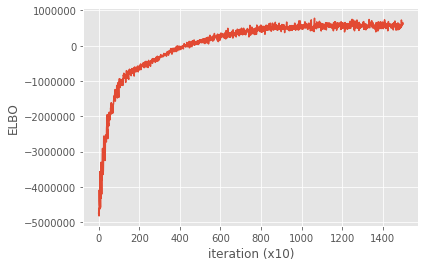

In [188]:
plot_loss(logger)

/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'linewidth'
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: No contour levels were found within the data range.
  


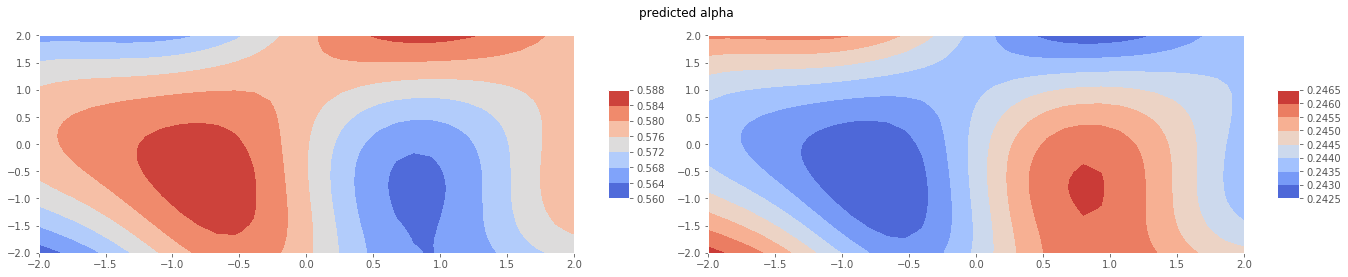

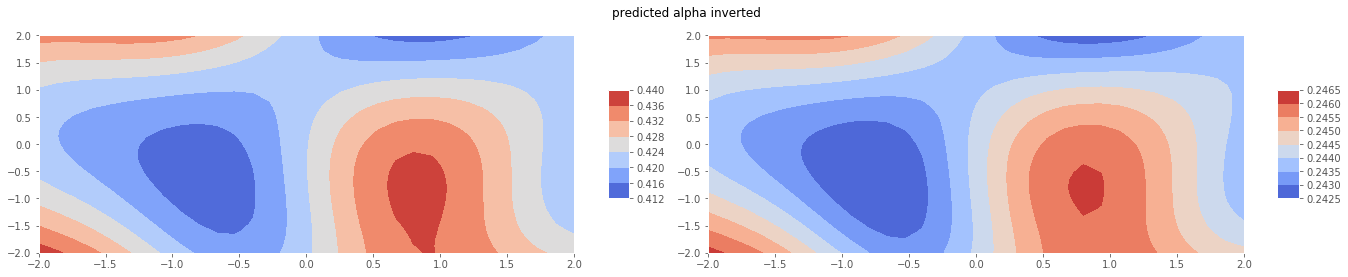

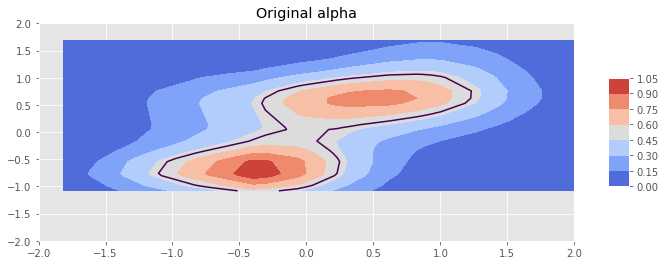

In [194]:
plot_model2D(m, a=True, a_true=a) # plot learned and true separation GP (alpha)

/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'linewidth'
  This is separate from the ipykernel package so we can avoid doing imports until


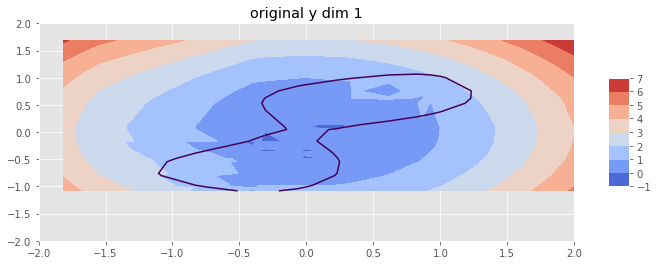

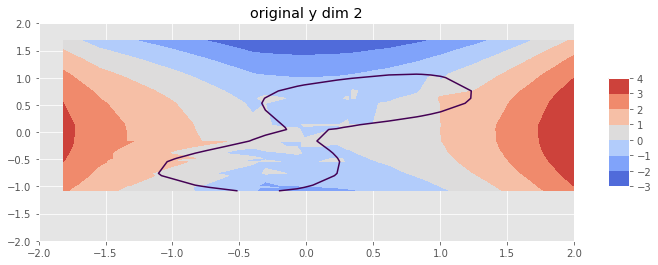

In [190]:
plot_model2D(m, y_true=True, y_a=a) # plot original data (one plot for each dimension)

/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'linewidth'
  This is separate from the ipykernel package so we can avoid doing imports until


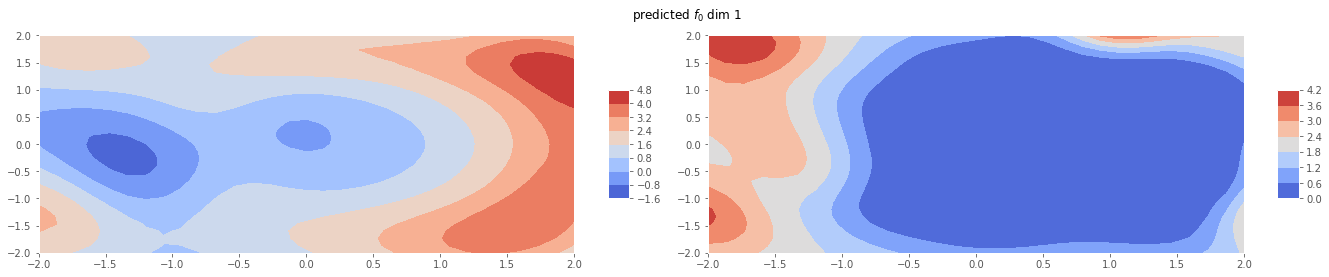

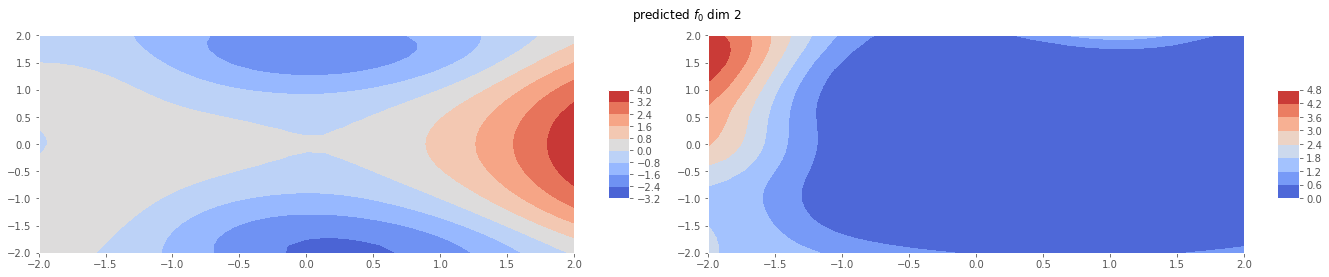

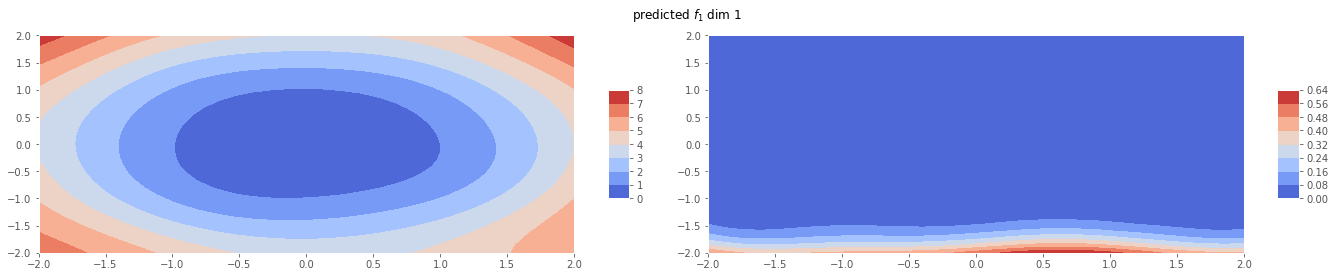

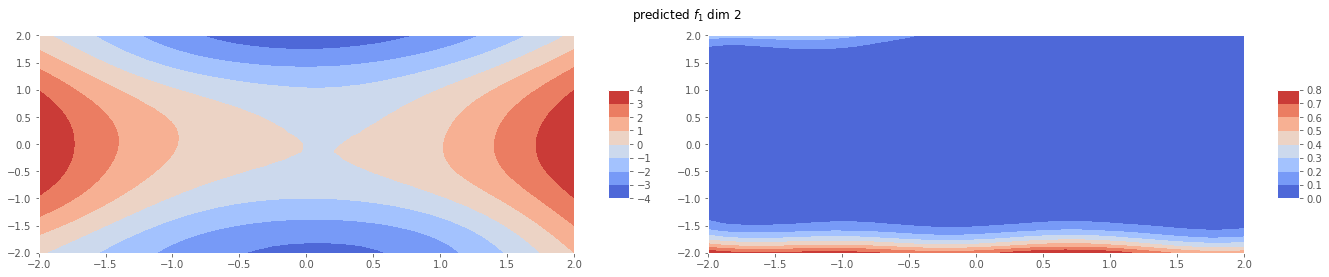

In [191]:
plot_model2D(m, f=True) # plot learned dynamics GPs (2 for each if the 2 dimensions)

(?, 2)
(?, 2)
(?, 2)
(?, 2)


(961, 2)


/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'linewidth'
  This is separate from the ipykernel package so we can avoid doing imports until


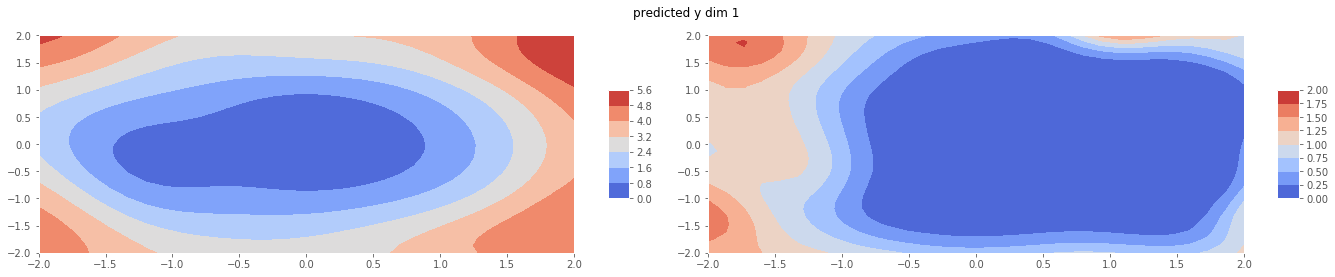

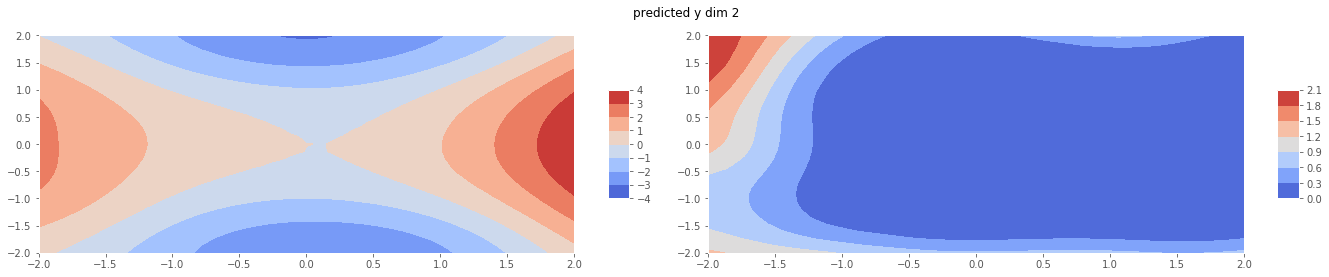

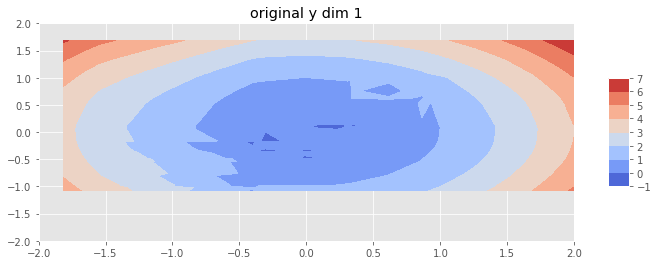

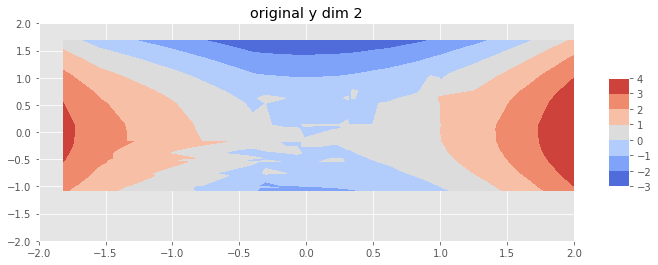

In [192]:
plot_model2D(m, y=True, y_true=True)
# plot_model2D?

In [193]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BMNSVGP/feature_h/Z,Parameter,None,(none),False,"(50, 2)",True,"[[1.0025788224880676, 0.08655783921110416], [0..."
BMNSVGP/features/0/feat_list/0/Z,Parameter,None,(none),False,"(50, 2)",True,"[[0.22729312543826063, 0.5302448033876472], [-..."
BMNSVGP/features/0/feat_list/1/Z,Parameter,None,(none),False,"(50, 2)",True,"[[-0.3065492505631564, 1.0013802782941377], [0..."
BMNSVGP/features/1/feat_list/0/Z,Parameter,None,(none),False,"(50, 2)",True,"[[-1.7570758277276575, -0.17203962336487288], ..."
BMNSVGP/features/1/feat_list/1/Z,Parameter,None,(none),False,"(50, 2)",True,"[[-1.7570758277276575, 1.3369790048584984], [0..."
BMNSVGP/kern_h/lengthscales,Parameter,None,+ve,True,"(2,)",True,"[1.1947821591783148, 2.618300967947723]"
BMNSVGP/kern_h/variance,Parameter,None,+ve,True,(),True,0.010043448175044102
BMNSVGP/kernels/0/kernels/0/lengthscales,Parameter,None,+ve,True,"(2,)",True,"[0.5680602882650956, 0.768373366141567]"
BMNSVGP/kernels/0/kernels/0/variance,Parameter,None,+ve,True,(),True,1.8908067935789763
BMNSVGP/kernels/0/kernels/1/lengthscales,Parameter,None,+ve,True,"(2,)",True,"[0.872185350904587, 0.8465288628795121]"


In [18]:
# session = gpflow.get_default_session()
# pa = session.run(m.p_a_0_tensor)
# # print(pa)
# plt.scatter(m.X, pa)

In [26]:
# saver = gpflow.saver.Saver()
# saver.save('saved_models/joint_inference', m)